# Part 2: eSTRs are enriched in putative regulatory regions

This notebook contains:

#### Figures:
* **Figure 2A**: Localization (TODO)
* **Figure 2B**: Overall motif enrichment (TODO)
* **Figure 2B-top**: Motif enrichment tissue grid (TODO)

#### Supplementary Figures:
* **Supplementary Figure ENRICHBYSCORE**: enrichment in genomic annotations as function of caviar score (TODO)
* **Supplementary Figure CHROMSTATES**: enrichment in chromatin states (TODO)
* **Supplementary Figure HISTONE**: enrichment in histone modification (TODO)
* **Supplementary Figure TFENRICH**: enrichment in ENCODE TF binding sites (TODO)

#### Supplementary Tables:
* **Supplementary Table ANNOTENRICH**: Enrichment in genomic annotations (coding/intron/UTR) (TODO)
* **Supplementary Table CODINGESTRS**: Table of all causal eSTRs in coding regions (TODO)

#### Statistics:
* Direction of effect (TODO)


In [242]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-enrich"
FIGPREFIX = "Figure2"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
allstrs = pd.read_csv(os.path.join(DATADIR, "all_analyzed_strs.tab"), sep="\t", names=["chrom","str.start"])

# All ref data
ref = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_annot_v2.bed"), sep="\t")
ref = pd.merge(ref, allstrs, on=["chrom","str.start"])
ref["str.start"] = ref["str.start"]+1

# ChromHMM ref data
ref_chromhmm = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_chromhmm.bed"), sep="\t")
ref_chromhmm["str.start"] = ref_chromhmm["start"]
ref_chromhmm = pd.merge(ref_chromhmm, allstrs, on=["chrom","str.start"])
ref_chromhmm["str.start"] = ref_chromhmm["str.start"]+1

# Histone ref data
ref_hist = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_histone.bed"), sep="\t")
ref_hist["str.start"] = ref_hist["start"]
ref_hist = pd.merge(ref_hist, allstrs, on=["chrom","str.start"])
ref_hist["str.start"] = ref_hist["str.start"]+1

# Histone ref data
ref_tf = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_tfbs.bed"), sep="\t")
ref_tf["str.start"] = ref_tf["start"]
ref_tf = pd.merge(ref_tf, allstrs, on=["chrom","str.start"])
ref_tf["str.start"] = ref_tf["str.start"]+1

Populating the interactive namespace from numpy and matplotlib


In [243]:
# Functions for enrichment calculations

CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal = scipy.stats.fisher_exact(t_causal)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        pval_causal.append(p_causal)

    
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def PlotEnrich(enrich, size=None):
    enrich = enrich.sort_values("odds.causal")
    w = 0.4
    fig = plt.figure()
    if size is not None: fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    ax.barh(range(enrich.shape[0]), np.log2(enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    ax.barh([item+w for item in range(enrich.shape[0])], np.log2(enrich["odds.estrs"]), color=ESTR_COLOR, height=w)
    ax.set_xlabel("Log2 OR", size=15)
    ax.set_yticks(range(enrich.shape[0]))
    ax.set_yticklabels([item.replace("_", " ") for item in enrich["annot"]], size=12)
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.axvline(x=0, linestyle="dashed", color="gray")

In [252]:
######## TODO DECIDE ON CUTOFF ##########
MIN_CAUSAL_SCORE = 0.1
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

# Supplementary Table ANNOTENRICH

In [253]:
all_annot = ["coding", "5utr", "3utr", "intron", "intergenic"]

annotenrich_by_cutoff = []
cutoffs = np.arange(0, 0.91, 0.05)
percall = []

for cutoff in cutoffs:
    c = estrs[estrs["score"]>=cutoff]
    percall.append(c.shape[0]*1.0/estrs.shape[0])
    annotenrich_by_cutoff.append(GetEnrichments(ref, estrs, c, all_annot))
    
annotenrich_by_cutoff[list(cutoffs).index(MIN_CAUSAL_SCORE)]

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
0,coding,0.687500,0.466667,16,75,217,4.127908,4.079264,0.210114,0.644464,5.016644e-06,4.007803e-19
1,5utr,0.571429,0.512690,56,197,657,4.879612,3.321041,0.349682,0.775739,2.802536e-20,1.896931e-37
2,3utr,0.510000,0.502137,100,468,1660,3.383690,3.071974,0.920411,0.963137,2.607018e-23,3.130247e-77
3,intron,0.516958,0.503807,1946,11951,77766,1.785640,1.980307,0.140604,0.410358,5.782969e-61,0.000000e+00
4,intergenic,0.487179,0.495434,1209,7446,94926,0.476199,0.453443,0.388258,0.437486,1.730416e-96,0.000000e+00


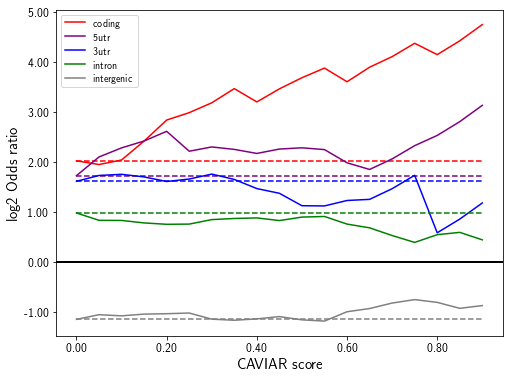

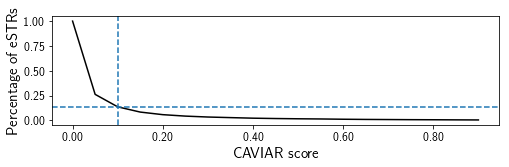

In [254]:
annot_colors = {
    "coding": "red",
    "intron": "green",
    "5utr": "purple",
    "3utr": "blue",
    "intergenic": "gray"
}
fig = plt.figure()
fig.set_size_inches((8, 6))
ax = fig.add_subplot(111)
for j in range(len(all_annot)):
    causal_enrich = np.log2([annotenrich_by_cutoff[i]["odds.causal"].values[j] for i in range(len(annotenrich_by_cutoff))])
    estr_enrich = np.log2([annotenrich_by_cutoff[i]["odds.estrs"].values[j] for i in range(len(annotenrich_by_cutoff))])
    color = annot_colors[all_annot[j]]
    ax.plot(cutoffs, causal_enrich, label=all_annot[j], color=color)
    ax.plot(cutoffs, estr_enrich, linestyle="dashed", color=color)
    ax.axhline(y=0, color="black")
ax.legend(loc="upper left");
ax.set_xlabel("CAVIAR score", size=15)
ax.set_ylabel("log2 Odds ratio", size=15)
ax.set_xticklabels(["%.2f"% item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);

fig = plt.figure()
fig.set_size_inches((8, 2))
ax = fig.add_subplot(111)
ax.plot(cutoffs, percall, color="black")
ax.set_xlabel("CAVIAR score", size=15)
ax.set_ylabel("Percentage of eSTRs", size=15)
ax.set_xticklabels(["%.2f"% item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);
ax.axhline(y=percall[list(cutoffs).index(MIN_CAUSAL_SCORE)], linestyle="dashed")
ax.axvline(x=MIN_CAUSAL_SCORE, linestyle="dashed")

# Supplementary Figure CHROMSTATES

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
10,Heterochrom,0.476364,0.496706,1375,9410,128302,0.249581,0.267074,0.084319,0.529461,0.000000e+00,0.000000e+00
7,Repetitive,1.000000,0.647059,2,17,143,0.732717,1.039150,0.500000,0.332306,1.000000e+00,8.953678e-01
9,Insulator,0.300000,0.448276,20,116,785,1.352915,1.337364,0.115318,0.307090,1.875732e-01,4.982209e-03
6,Repressed,0.547297,0.488579,148,788,5586,1.425097,1.275676,0.285217,0.544807,7.897432e-05,1.538819e-09
5,Strong_Enhancer,0.475248,0.512635,101,554,2843,1.931432,1.888461,0.690826,0.580771,4.214551e-09,1.446654e-35
2,Weak_Enhancer,0.531532,0.522109,222,1176,6081,2.026192,1.899025,0.382978,0.136931,8.507075e-20,5.122545e-73
8,Poised_Promoter,0.363636,0.551724,11,58,265,2.241690,2.161307,0.548828,0.511842,1.952850e-02,1.559083e-06
0,Weak_Txn,0.524740,0.502704,768,4438,19688,2.426619,2.592231,0.181799,0.729910,5.442068e-85,0.000000e+00
4,Txn_Transition,0.615385,0.471875,52,320,1122,2.534953,3.106469,0.126347,0.341958,8.237992e-09,2.858898e-54
3,Txn_Elongation,0.515464,0.499814,485,2695,8874,3.326226,3.723644,0.525010,1.000000,2.681062e-97,0.000000e+00


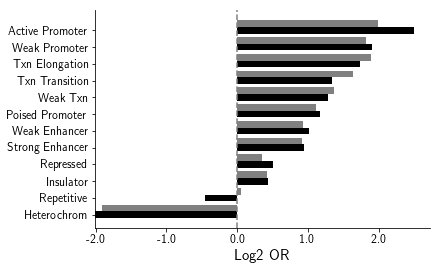

In [255]:
hmm_annot = [item for item in ref_chromhmm.columns if item not in ["chrom","start","end","period","motif","str.start"]]
hmm_enrich = GetEnrichments(ref_chromhmm, estrs, causal, hmm_annot, annot_col=False)
hmm_enrich = hmm_enrich.sort_values("odds.causal", ascending=True)

PlotEnrich(hmm_enrich)
hmm_enrich

# Supplementary Figure HISTONE

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
7,H3K27me3,0.583333,0.506849,12,73,402,1.591916,1.711466,0.774414,1.000000,1.374239e-01,8.183027e-05
5,H3K4me1,0.494737,0.557239,95,594,3128,1.636523,1.829848,1.000000,0.005931,1.169353e-05,9.756293e-35
1,H3K9ac,0.481132,0.485929,106,533,2451,2.379471,2.171253,0.770919,0.544284,2.264547e-14,6.859681e-48
6,H3K36me3,0.506173,0.494033,81,419,1818,2.444552,2.334420,1.000000,0.845099,4.914080e-12,3.472199e-44
0,H4K20me1,0.500000,0.520000,4,25,88,2.462133,3.058784,1.000000,1.000000,8.695577e-02,1.280312e-05
2,H3K79me2,0.538889,0.524070,180,914,3632,2.791054,2.665495,0.332579,0.154897,2.285196e-30,2.126480e-118
8,H3K27ac,0.600000,0.523810,185,840,3496,2.998010,2.498276,0.007954,0.178388,9.167088e-35,2.206865e-97
4,H3K4me2,0.540323,0.511450,248,1179,4535,3.149152,2.811767,0.227554,0.448938,7.170017e-49,6.595030e-165
9,H2AFZ,0.612903,0.527778,93,396,1488,3.514822,2.828887,0.037514,0.291282,7.275632e-23,3.076794e-58
3,H3K4me3,0.586387,0.519133,191,784,2570,4.339941,3.477258,0.020347,0.300332,1.011011e-56,3.971824e-150


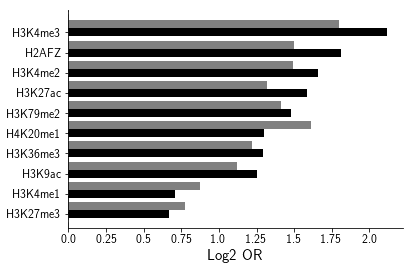

In [256]:
hist_annot = [item for item in ref_hist.columns if item not in ["chrom","start","end","period","motif","str.start"]]
hist_enrich = GetEnrichments(ref_hist, estrs, causal, hist_annot, annot_col=False)
hist_enrich = hist_enrich.sort_values("odds.causal", ascending=True)

PlotEnrich(hist_enrich)
hist_enrich

# Supplementary Figure TFENRICH

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in double_scalars


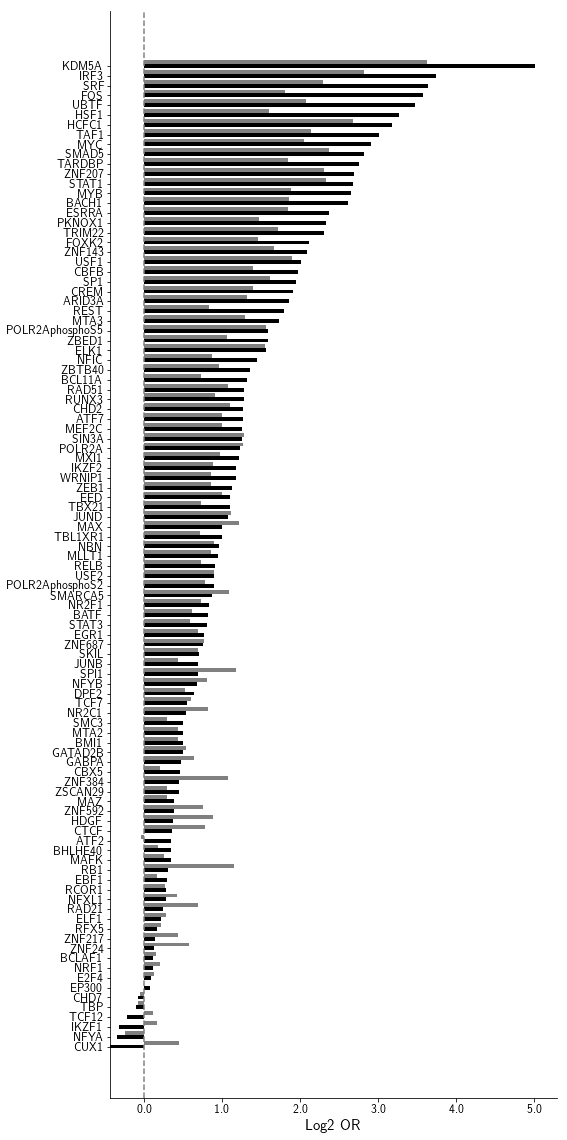

In [257]:
tf_annot = [item for item in ref_tf.columns if item not in ["chrom","start","end","period","motif","str.start"]]
tf_enrich = GetEnrichments(ref_tf, estrs, causal, tf_annot, annot_col=False)
tf_enrich = tf_enrich[tf_enrich["num.causal"]>=3].sort_values("odds.causal", ascending=False)
tf_enrich["signif"] = tf_enrich["pval.causal"]<=0.05/tf_enrich.shape[0]
PlotEnrich(tf_enrich, size=(8, 20))

#pd.merge(causal, ref_tf[ref_tf["TARDBP"]>0][["chrom","str.start","motif"]], on=["chrom","str.start"])

# Figure 2B: Motifs

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in double_scalars


(0.7450681231925815, 0.0005991851491727926)


,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs,perc.causal
108,CCCGG,1.000000,0.857143,3,7,13,15.513448,8.988086,0.250000,0.125000,1.695835e-03,2.410721e-04,0.428571
105,CCCCG,0.666667,0.555556,9,18,41,14.568292,6.031910,0.507812,0.814529,6.422837e-08,1.754862e-07,0.500000
104,CCCCCG,0.500000,0.636364,4,11,24,10.344809,6.519833,1.000000,0.548828,1.017315e-03,2.728228e-05,0.363636
90,AGGCGG,1.000000,0.625000,3,8,18,10.341998,6.163406,0.250000,0.726563,4.507727e-03,4.562470e-04,0.375000
85,AGCCCC,0.800000,0.636364,5,11,35,8.622767,3.531326,0.375000,0.548828,4.969502e-04,1.370781e-03,0.454545
106,CCCCGG,1.000000,0.636364,3,11,23,7.756273,7.063198,0.250000,0.548828,9.117856e-03,1.649628e-05,0.272727
109,CCG,0.590909,0.575758,22,66,210,6.079831,3.538262,0.523467,0.267812,1.436869e-10,1.036650e-14,0.333333
2,AAAAAG,0.727273,0.589744,11,39,213,2.819613,1.727651,0.226563,0.336784,2.751030e-03,3.443133e-03,0.282051
51,ACACAC,0.500000,0.666667,4,12,88,2.462133,1.216186,1.000000,0.387695,8.695577e-02,5.032792e-01,0.333333
82,AGC,0.400000,0.345455,10,55,293,1.828209,1.781939,0.753906,0.030029,7.937480e-02,3.093271e-04,0.181818


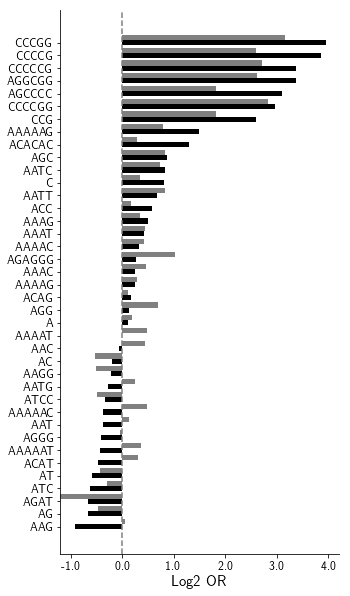

In [258]:
motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
motifs = list(motifs[motifs["str.start"]>=10]["motif"])
ref_motif = ref[["chrom","str.start","motif"]].copy()
ref_motif["annot"] = ref_motif["motif"]
motif_enrich = GetEnrichments(ref_motif, estrs, causal, motifs, annot_col=True)
motif_enrich = motif_enrich[motif_enrich["num.causal"]>=3]

# Interesting relationship between odds ratio and perc positive
d = motif_enrich
x = d[d["pval.causal"]<=0.05]
print(scipy.stats.pearsonr(np.log2(x["odds.causal"]), x["dir.causal"]))

PlotEnrich(motif_enrich, size=(5, 10))
motif_enrich["perc.causal"] = motif_enrich["num.causal"]*1.0/motif_enrich["num.estrs"]
motif_enrich.sort_values("odds.causal", ascending=False)

# Direction of effect

In [259]:
print("all estrs")
print(sum(estrs["beta"]>0)*1.0/estrs.shape[0])
print(scipy.stats.binom_test(sum(estrs["beta"]>0), estrs.shape[0]))
print("causal estrs")
print(sum(causal["beta"]>0)*1.0/causal.shape[0])
print(scipy.stats.binom_test(sum(causal["beta"]>0), causal.shape[0]))

print("enriched motifs causal enriched for pos effect sizes")
enriched_motifs = list(motif_enrich[(motif_enrich["pval.causal"]<=0.05/motif_enrich.shape[0]) & (motif_enrich["odds.causal"]>1)]["annot"])
x = causal[causal["motif"].apply(lambda x: x in enriched_motifs)]
print(sum(x["beta"]>0)*1.0/ x.shape[0])
print(scipy.stats.binom_test(sum(x["beta"]>0), x.shape[0], alternative="greater"))

all estrs
0.5034623058565784
0.2709664693644683
causal estrs
0.5086355785837651
0.3168234161828592
enriched motifs causal enriched for pos effect sizes
0.6062992125984252
0.010340392009458764


# Figure 2B: Motif tissue grid

# Figure 2A: Localization